In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn import metrics

In [2]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Correlation map

<Axes: >

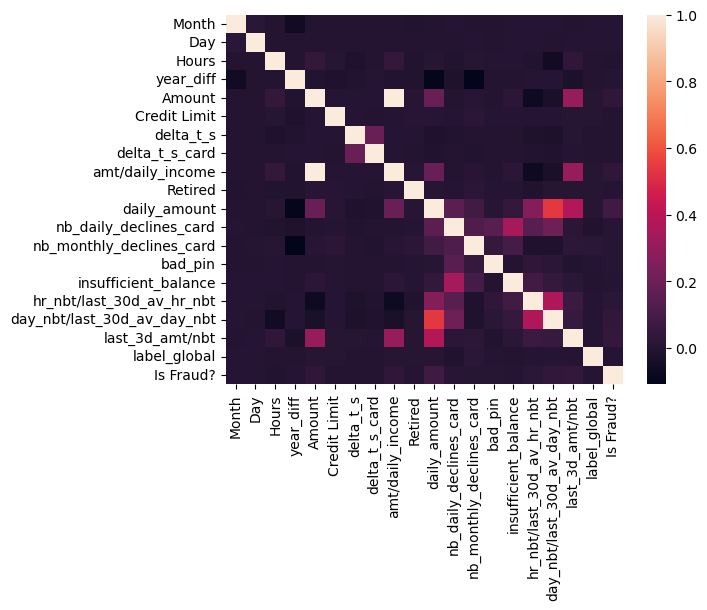

In [3]:
sns.heatmap(df_cct[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?']].corr())

In [3]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?'],
      dtype='object')

### Preprocessing (code to create standarized (by User) dataset) - DO NOT RUN

In [19]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_cct.loc[:,~df_cct.columns.isin(["User","Card","label_global","Retired", "bad_pin", "insufficient_balance","Is Fraud?"])].select_dtypes(include=numerics).columns.to_list()
cat = df_cct.select_dtypes(include=['object']).columns.to_list()


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df = pd.DataFrame()
for i in range(2000):
    user_i = df_cct[df_cct["User"] == i]
    user_i[num] = scaler.fit_transform(user_i[num])
    df = pd.concat([df,user_i], axis=0)


In [51]:
#df.to_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Encode categorical variables

In [3]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [4]:
# Pour "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# Pour "Card Type"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [6]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)'],
      dtype='object')

### Manually create train/test datasets

In [20]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',
        "label_global","Is Fraud?"]
df_selec = df_cct[features] # 21 features
X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)']]
y = df_selec["Is Fraud?"]

In [18]:
df_selec.groupby("label_global").min() # cluster 6 has the smallest number of samples

,Month,Day,Hours,year_diff,Amount,Credit Limit,delta_t_s,delta_t_s_card,amt/daily_income,Retired,...,bad_pin,insufficient_balance,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt,Chip Transaction,Online Transaction,Swipe Transaction,Debit (Prepaid),Is Fraud?
label_global,,,,,,,,,,,,,,,,,,,,,
-1,-1.5,-1.777778,-17.0,-5.750000,-69.588957,-41645.0,-0.969512,-1.028169,-69.588957,0,...,0,0,-5.470588,-2.575246,-5.184050,0.0,0.0,0.0,0.0,0
0,-10.0,-1.777778,-17.0,-5.750000,-230.287805,-41645.0,-1.509127,-1.509127,-230.287805,0,...,0,0,-7.965517,-2.700000,-7.173156,0.0,0.0,0.0,0.0,0
1,-1.5,-1.363636,-17.0,-3.400000,-52.302086,-39203.0,-1.002243,-1.030516,-52.302086,0,...,0,0,-6.600000,-2.290517,-6.545954,0.0,0.0,0.0,0.0,0
2,-1.2,-1.071429,-17.0,-3.400000,-88.513966,-39203.0,-0.932039,-0.897395,-88.513966,0,...,0,0,-7.333333,-2.040104,-5.126416,0.0,0.0,0.0,0.0,0
3,-1.4,-1.363636,-14.0,-2.500000,-76.782123,-30841.0,-0.953930,-0.971360,-76.782123,0,...,0,0,-7.173913,-2.247268,-3.012836,0.0,0.0,0.0,0.0,0
4,-1.2,-1.142857,-13.0,-1.500000,-46.863884,-31442.0,-0.849099,-0.809335,-46.863884,0,...,0,0,-3.840000,-2.265197,-4.862563,0.0,0.0,0.0,0.0,0
5,-1.2,-1.166667,-7.0,-1.833333,-26.301614,-6541.0,-0.698432,-0.873096,-26.301614,0,...,0,0,-3.428571,-1.678344,-2.679671,0.0,0.0,0.0,0.0,0
6,-1.2,-1.000000,-5.0,-1.125000,-13.534251,-2759.0,-0.709505,-0.743280,-13.534251,0,...,0,0,-2.185299,-1.643555,-3.370202,0.0,0.0,0.0,0.0,0


In [30]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)

In [34]:
df_trainval = df_selec.iloc[X_train_val.index]

In [62]:
df_cluster_stat = pd.DataFrame(columns = ["cluster", "count", "percentage_of_frauds"])
for i in range(-1, 7, 1):
    share = len(df_trainval[(df_trainval["label_global"] == i) & (df_trainval["Is Fraud?"] == 1)]) / len(df_trainval[df_trainval["label_global"] == i]) 
    df_cluster_stat.loc[len(df_cluster_stat)] = [i, len(df_trainval[df_trainval["label_global"] == i]),share]
df_cluster_stat["cluster"] = df_cluster_stat["cluster"].astype(int)

In [63]:
df_cluster_stat

,cluster,count,percentage_of_frauds
0,-1,102800.0,0.001089
1,0,17803706.0,0.001217
2,1,513628.0,0.001053
3,2,501117.0,0.001319
4,3,453143.0,0.001620
5,4,65702.0,0.000609
6,5,65701.0,0.000837
7,6,3723.0,0.000000


In [64]:
import random # manually creating train dataset (80,000 from each cluster except for cluster 6)
# random sampling among each cluster created from DBSCAN work
# in total, +560000 rows
random.seed(42)
df_train = pd.DataFrame()
for i in range(-1,7,1) :
    df_cluster = df_trainval[df_trainval["label_global"] == i]
    df_small_cluster = df_trainval[df_trainval["label_global"] == 6]
    df_cluster_fraud = df_cluster[df_cluster["Is Fraud?"] == 1]
    df_cluster_nofraud = df_cluster[df_cluster["Is Fraud?"] == 0]
    df_rs = pd.concat([df_cluster_fraud.sample(int(df_cluster_stat.loc[i+1, "percentage_of_frauds"]*len(df_small_cluster)),random_state = 42), 
    df_cluster_nofraud.sample(int((1-df_cluster_stat.loc[i+1, "percentage_of_frauds"])*len(df_small_cluster)),random_state = 42)], axis = 0)
    df_train = pd.concat([df_train, df_rs], axis= 0)


In [65]:
df_train

,Month,Day,Hours,year_diff,Amount,Credit Limit,delta_t_s,delta_t_s_card,amt/daily_income,Retired,...,insufficient_balance,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt,Chip Transaction,Online Transaction,Swipe Transaction,Debit (Prepaid),label_global,Is Fraud?
8090944,0.666667,-0.533333,-4.000000,-0.428571,-0.256806,0.0,0.003646,-0.679121,-0.256806,0,...,0,-0.115553,0.478553,-0.148341,0.0,1.0,0.0,0.0,-1,1
13885636,0.833333,0.133333,0.400000,0.333333,10.983009,0.0,-0.396991,-0.396991,10.983009,0,...,0,0.090050,1.402782,9.391833,0.0,1.0,0.0,1.0,-1,1
2206269,-0.666667,0.133333,-3.000000,-0.090909,18.148177,0.0,-0.188875,-0.432476,18.148177,0,...,0,0.186054,6.036018,7.026343,0.0,1.0,0.0,0.0,-1,1
2170608,-0.833333,0.600000,-0.428571,-1.600000,0.272702,-1.0,-0.559908,-0.487189,0.272702,0,...,0,0.398148,2.515873,-0.229932,0.0,1.0,0.0,0.0,-1,1
19106154,0.333333,-0.333333,0.500000,0.142857,-0.171779,0.0,-0.087576,-0.086869,-0.171779,0,...,0,-1.123636,-0.845934,-0.461224,0.0,0.0,1.0,0.0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18012264,-0.142857,-0.133333,-0.181818,0.500000,-0.640645,0.0,0.728788,1.290230,-0.640645,0,...,0,0.084314,-0.674037,-1.536527,1.0,0.0,0.0,0.0,6,0
22135680,-1.000000,-0.800000,-0.272727,-0.600000,-0.253964,3393.0,0.266730,0.173048,-0.253964,0,...,0,-0.129257,-0.675036,-1.268640,1.0,0.0,0.0,0.0,6,0
8401820,-0.200000,0.133333,0.428571,-0.125000,-0.017272,0.0,-0.129630,-0.131868,-0.017272,0,...,0,-0.080322,-0.224934,-1.238306,0.0,0.0,1.0,0.0,6,0
17726637,-0.857143,-0.533333,-0.875000,-0.500000,-0.418223,0.0,0.466000,0.422701,-0.418223,0,...,0,0.122228,-1.261771,-0.868459,0.0,0.0,1.0,0.0,6,0


In [66]:
#X_train, y_train, contains around 600 frauds
X_train = df_train.drop(["label_global","Is Fraud?"], axis = 1)
y_train = df_train["Is Fraud?"]

In [67]:
# retrieving frauds for later use
i_fraud = y_train[y_train.values == 1].index
X_train_fraud = X_train.loc[i_fraud]
i_no_fraud = y_train[y_train.values == 0].index
X_train_no_fraud = X_train.loc[i_no_fraud]

In [68]:
# test set : 55,000 rows, contains 5,000 frauds
df_rest = df_selec[~df_selec.index.isin(df_train.index)] # selecting the resting rows not taken for train set
df_rest_fraud = df_rest[df_rest["Is Fraud?"] == 1]
df_rest_no_fraud = df_rest[df_rest["Is Fraud?"] == 0]
df_val = pd.concat([df_rest_fraud.sample(5000, random_state = 42), df_rest_no_fraud.sample(50000, random_state = 42)], axis = 0)
df_val.sort_index(inplace=True)

In [69]:
X_val = df_val.drop(["label_global", "Is Fraud?"], axis = 1)
y_val = df_val["Is Fraud?"]

### Base - first model

In [90]:
# Build and train model without any hyperparameters
decision_tree = DecisionTreeClassifier(class_weight={0: 0.050000000000000044, 1: 0.95},
                       max_depth=4, max_features='auto', random_state=42)
decision_tree.fit(X_train, y_train)
print(decision_tree.tree_.max_depth)
# Apply model to validation data
y_pred = decision_tree.predict(X_val)


4


/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Classification metrics: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     50000
           1       0.73      0.03      0.05      5000

    accuracy                           0.91     55000
   macro avg       0.82      0.51      0.50     55000
weighted avg       0.89      0.91      0.87     55000



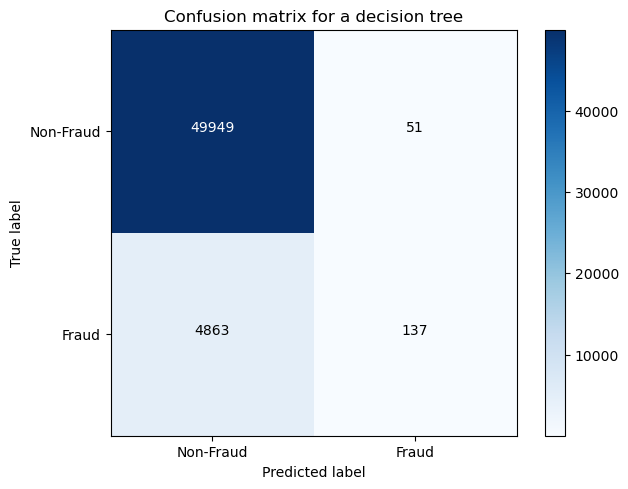

In [91]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred))
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()


cnf_matrix_dtree = confusion_matrix(y_val, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

### SHAP values

In [25]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(decision_tree)

In [16]:
# selecting 15,000 frauds and 15,000 non frauds from train set
# otherwise, computation time is too big

X_train_shap = pd.concat([X_train_fraud, X_train_no_fraud.sample(len(X_train_fraud), random_state = 42)], axis = 0)

In [26]:
shap_values = explainer.shap_values(X_train_shap)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


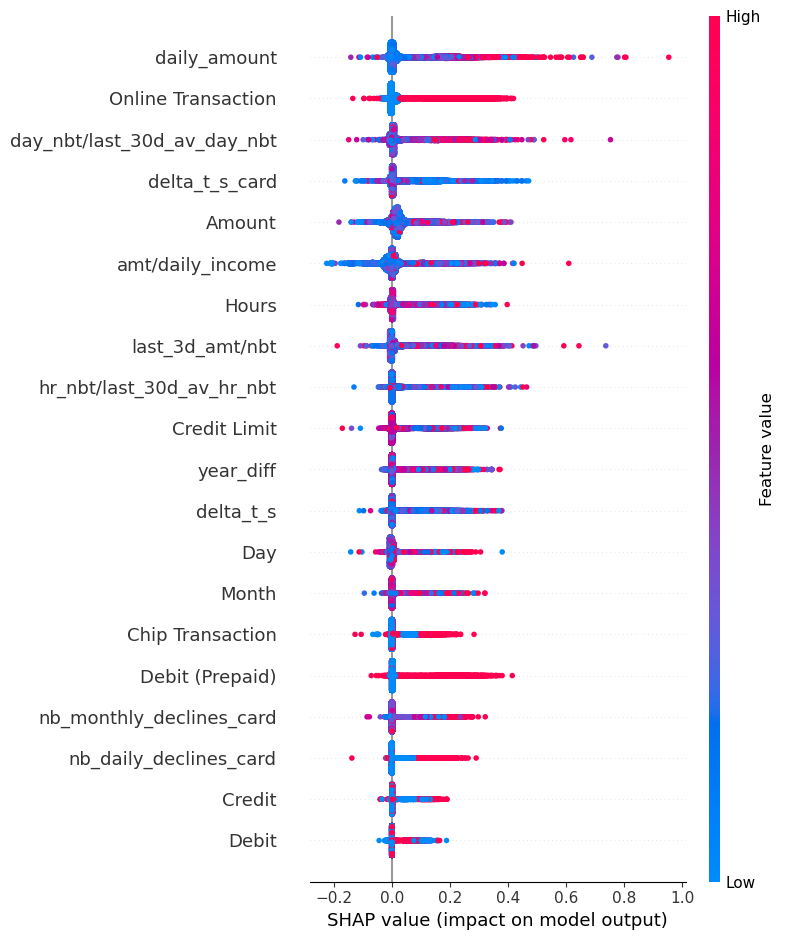

In [29]:
shap.summary_plot(shap_values[1], X_train_shap)

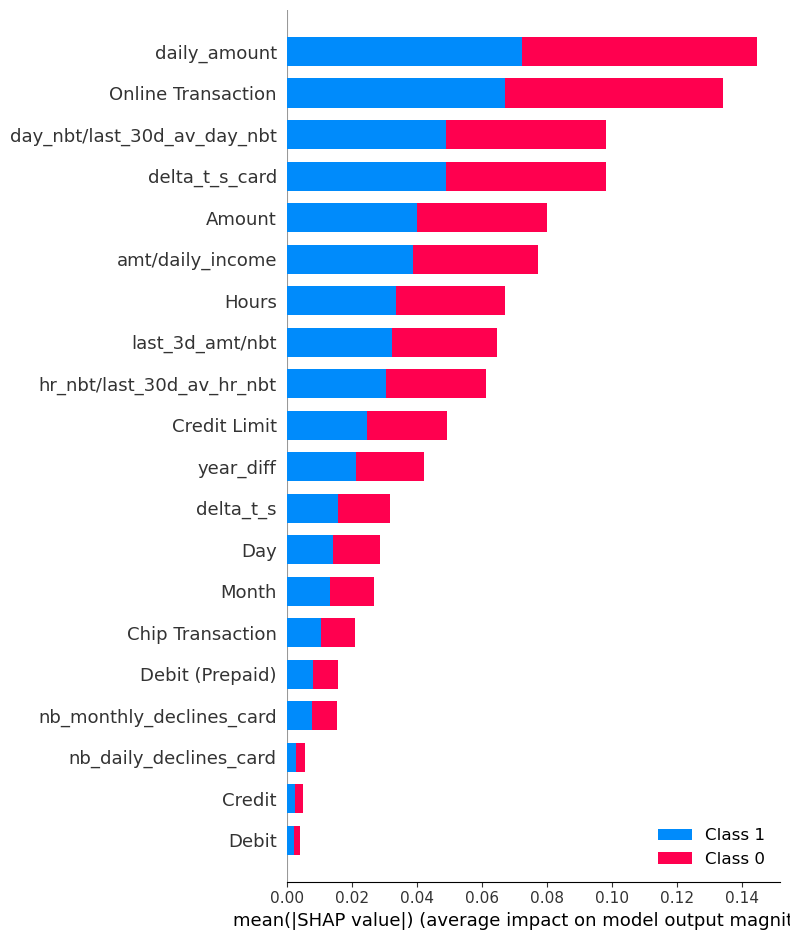

In [27]:
shap.summary_plot(shap_values, X_train_shap ,feature_names = X_train_shap.columns, plot_type="bar") 
# we can drop the 7 last ones : mastercard, amex, visa, discover, debit, credit, nb_daily_declines_card

### Tuning Hyperparameters

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
            "min_samples_leaf" : [i for i in range(1,100,5)],
              'class_weight': [{1: i/100, 0: 1-i/100} for i in range(90,100)],
              'max_depth' : [i for i in range(1,10)],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, scoring = 'f1', cv = 3, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10800 candidates, totalling 32400 fits


/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/mamba/lib/pytho

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': [{0: 0.09999999999999998, 1: 0.9},
                                          {0: 0.08999999999999997, 1: 0.91},
                                          {0: 0.07999999999999996, 1: 0.92},
                                          {0: 0.06999999999999995, 1: 0.93},
                                          {0: 0.06000000000000005, 1: 0.94},
                                          {0: 0.050000000000000044, 1: 0.95},
                                          {0: 0.040000000000000036, 1: 0.96},
                                          {0: 0.030000000000000027, 1: 0.97},
                                          {0: 0.020000000000000018, 1: 0.98},
                                          {0: 0.010000000000000009, 1: 0.99}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                              46, 51, 56, 61, 66, 71, 76, 81,
                                              86, 91, 96]},
             scoring='f1', verbose=True)

In [92]:
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)

/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(class_weight={0: 0.050000000000000044, 1: 0.95},
                       max_depth=4, max_features='auto', random_state=42)

Classification metrics: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     50000
           1       0.73      0.03      0.05      5000

    accuracy                           0.91     55000
   macro avg       0.82      0.51      0.50     55000
weighted avg       0.89      0.91      0.87     55000



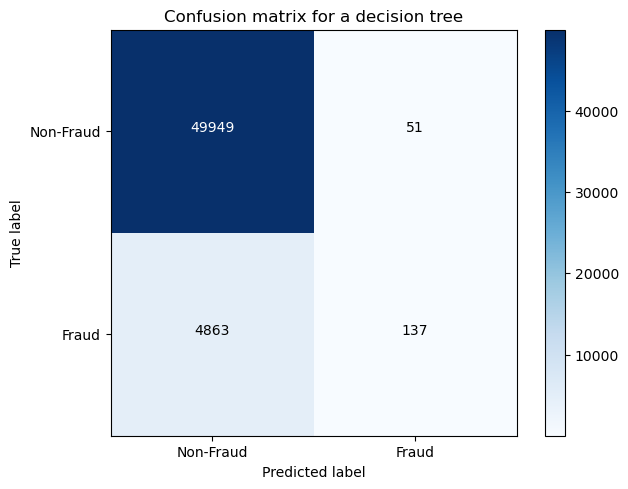

In [93]:
y_pred = final_model.predict(X_val)
# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred))
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()


cnf_matrix_dtree = confusion_matrix(y_val, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

In [70]:
df_f1_score = pd.DataFrame(columns = ["min_samples_leaf", "f1score"])
for i in range(1, 100, 5):
    dt = DecisionTreeClassifier(class_weight = {1:0.9,0:0.1}, min_samples_leaf=i, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score.loc[len(df_f1_score)] = [i, score]
df_f1_score    

,min_samples_leaf,f1score
0,1.0,0.141726
1,6.0,0.256875
2,11.0,0.279739
3,16.0,0.303060
4,21.0,0.298721
5,26.0,0.286955
6,31.0,0.310567
7,36.0,0.324253
8,41.0,0.325270
9,46.0,0.319002


In [87]:
df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]

66.0

Text(0.5, 1.0, 'f1-score according to min_samples_leaf (decision tree)')

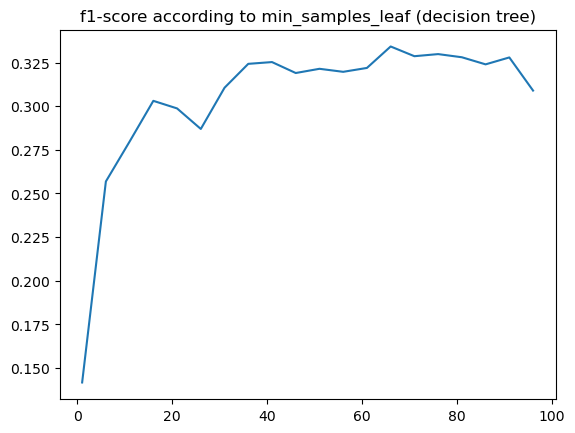

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score.iloc[:,0].values, df_f1_score.iloc[:,1].values)
plt.title('f1-score according to min_samples_leaf (decision tree)')

In [72]:
df_f1_score2 = pd.DataFrame(columns = ["max_depth", "f1score"])
for i in range(1, 26):
    dt = DecisionTreeClassifier(class_weight = {1:0.9,0:0.1}, min_samples_leaf=65, max_depth=i, random_state= 42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score2.loc[len(df_f1_score2)] = [i, score]
df_f1_score2

,max_depth,f1score
0,1.0,0.000000
1,2.0,0.000000
2,3.0,0.241115
3,4.0,0.287403
4,5.0,0.315039
5,6.0,0.327863
6,7.0,0.296844
7,8.0,0.322983
8,9.0,0.334204
9,10.0,0.334204


Text(0.5, 1.0, 'f1-score according to max_depth (decision tree)')

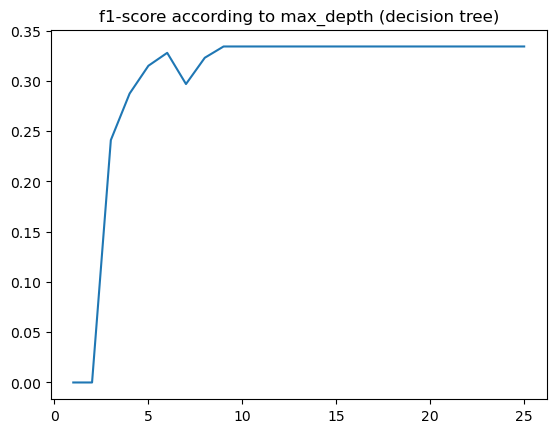

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score2.iloc[:,0].values, df_f1_score2.iloc[:,1].values)
plt.title('f1-score according to max_depth (decision tree)')

In [74]:
df_f1_score3 = pd.DataFrame(columns = ["max_features", "f1score"])
max_feat = [5, 10, 15, 20, 0.3, 0.5, 0.7, 0.9, "auto", "sqrt", "log2", None]
for i in range(len(max_feat)):
    dt = DecisionTreeClassifier(class_weight = {1:0.9,0:0.1}, min_samples_leaf=65, max_depth=9, max_features=max_feat[i], random_state= 42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score3.loc[len(df_f1_score3)] = [max_feat[i], score]
df_f1_score3

/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


,max_features,f1score
0,5.0,0.231712
1,10.0,0.313110
2,15.0,0.295588
3,20.0,0.349176
4,0.3,0.312521
5,0.5,0.313110
6,0.7,0.329139
7,0.9,0.335728
8,auto,0.275792
9,sqrt,0.275792


In [ ]:
df_f1_score3 = pd.DataFrame(columns = ["max_features", "f1score"])
max_feat = [5, 10, 15, 20, 0.3, 0.5, 0.7, 0.9, "auto", "sqrt", "log2", None]
for i in range(len(max_feat)):
    dt = DecisionTreeClassifier(class_weight = {1:0.9,0:0.1}, min_samples_leaf=65, max_depth=9, max_features=max_feat[i], random_state= 42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score3.loc[len(df_f1_score3)] = [max_feat[i], score]
df_f1_score3

/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


,max_features,f1score
0,5.0,0.293418
1,10.0,0.335077
2,15.0,0.357590
3,20.0,0.332516
4,0.3,0.282873
5,0.5,0.319908
6,0.7,0.383899
7,0.9,0.338152
8,auto,0.204973
9,sqrt,0.237300


### Evaluating

In [35]:
# Build and train model
decision_tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth = 30)
decision_tree.fit(X_train, y_train)
# Apply model to validation data
y_pred = decision_tree.predict(X_test)

In [36]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    480000
           1       0.84      0.16      0.26     17913

    accuracy                           0.97    497913
   macro avg       0.90      0.58      0.62    497913
weighted avg       0.96      0.97      0.96    497913



In [26]:
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()

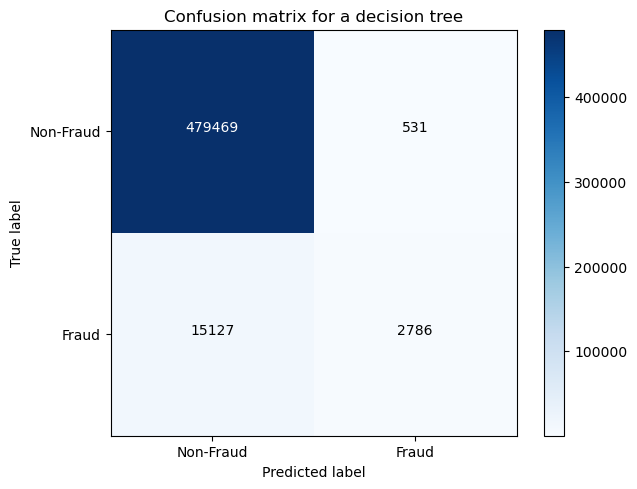

In [37]:

cnf_matrix_dtree = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
cost = fp*15 + fn*45 - tp*45
cost

424275

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(min_samples_leaf=10)
rforest.fit(X_train,y_train)

RandomForestClassifier(max_depth=20)

In [31]:
y_pred_rf = rforest.predict(X_test)

In [32]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred_rf))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    480000
           1       0.99      0.06      0.10     17913

    accuracy                           0.97    497913
   macro avg       0.98      0.53      0.54    497913
weighted avg       0.97      0.97      0.95    497913



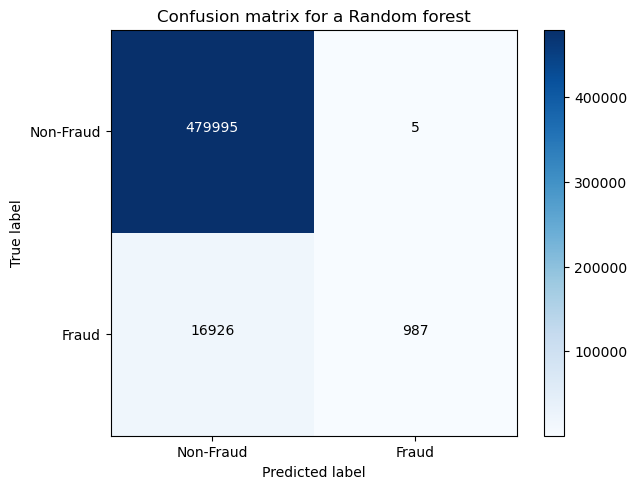

In [33]:
cnf_matrix_dtree = confusion_matrix(y_test, y_pred_rf)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a Random forest')
plt.show()